In [1]:
#!pip install gensim
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, GRU, LSTM
from tensorflow.keras import regularizers
from gensim.models import Word2Vec
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# python.exe -m 
#!pip install --upgrade pip
#!pip install --upgrade gensim

In [14]:
# use word2vec
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data = load_data("train_try_seraj.json")

texts = [data[key]["text"] for key in data]
words = [sentence.split() for sentence in texts]
nested_labels = [data[key]["labels"] for key in data]


In [15]:
word2vec_model = Word2Vec(words, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors = {}
for word in word2vec_model.wv.index_to_key:
    try:
        word_vectors[word.lower()] = word2vec_model.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

# Handle out-of-vocabulary (OOV) words in get_word_vector function
def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors:
        return word_vectors[word_lower]
    else:
        return np.zeros(word2vec_model.vector_size)
    
word_embeddings = [[get_word_vector(word)  for word in sentence] for sentence in words]


In [16]:
for sentence in word_embeddings:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 70, 100)  from (9435, variable_length, 70)           
for i in range(len(word_embeddings)):
    word_embeddings[i] = np.array(word_embeddings[i])
word_embeddings = np.array(word_embeddings)
word_embeddings.shape            

(9435, 70, 100)

In [17]:
flat_labels = [label for sublist in nested_labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in nested_labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]
print(label2idx)

{'I_GPE': 0, 'I_DATE': 1, 'B_STATUTE': 2, 'I_OTHER_PERSON': 3, 'B_WITNESS': 4, 'I_PROVISION': 5, 'I_PRECEDENT': 6, 'B_RESPONDENT': 7, 'B_ORG': 8, 'I_JUDGE': 9, 'O': 10, 'B_PETITIONER': 11, 'B_PROVISION': 12, 'I_COURT': 13, 'B_GPE': 14, 'I_WITNESS': 15, 'B_COURT': 16, 'B_DATE': 17, 'I_CASE_NUMBER': 18, 'B_OTHER_PERSON': 19, 'I_RESPONDENT': 20, 'B_CASE_NUMBER': 21, 'B_JUDGE': 22, 'I_STATUTE': 23, 'B_PRECEDENT': 24, 'I_ORG': 25, 'I_PETITIONER': 26}


In [18]:
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)
# labels_idx[0]

for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape


(9435, 70, 27)





45/45 [==============================] - 1s 11ms/step
Epoch 1: Training Macro-F1-score: 0.0488486795594851, Validation Macro-F1-score: 0.049134703411826935
Epoch 1: Training Accuracy: 0.9232697486877441, Validation Accuracy: 0.9277744293212891
45/45 [==============================] - 1s 12ms/step
Epoch 2: Training Macro-F1-score: 0.06323814827658733, Validation Macro-F1-score: 0.06172540814774386
Epoch 2: Training Accuracy: 0.9328843951225281, Validation Accuracy: 0.9281578063964844
45/45 [==============================] - 1s 12ms/step
Epoch 3: Training Macro-F1-score: 0.08999915857602714, Validation Macro-F1-score: 0.0912900254811703
Epoch 3: Training Accuracy: 0.9340245723724365, Validation Accuracy: 0.9315980672836304
45/45 [==============================] - 1s 12ms/step
Epoch 4: Training Macro-F1-score: 0.1172669298835159, Validation Macro-F1-score: 0.11752065188787467
Epoch 4: Training Accuracy: 0.9355370402336121, Validation Accuracy: 0.9333232641220093
45/45 [===============

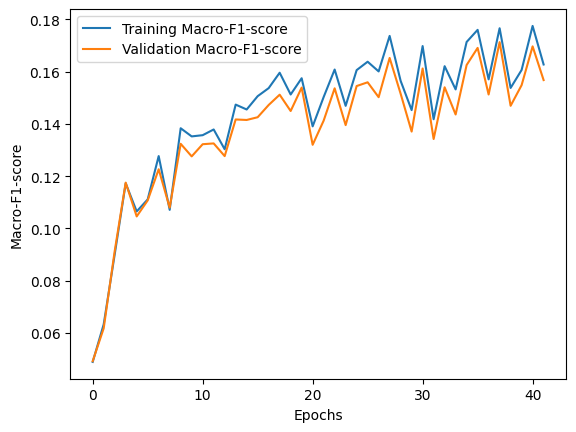

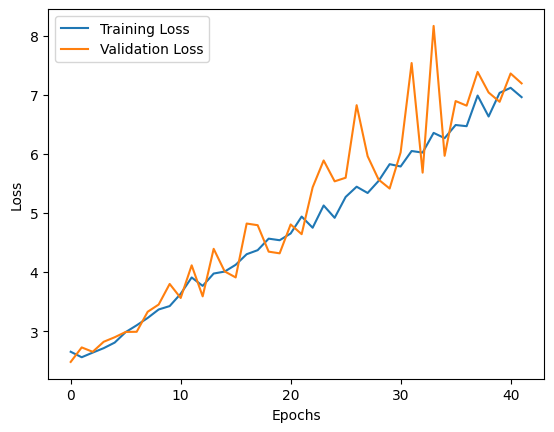

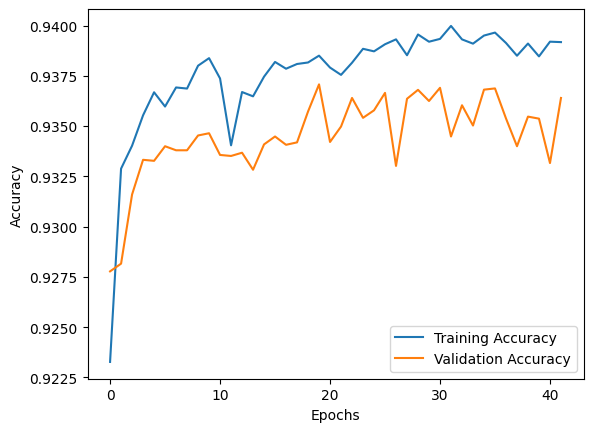

In [10]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(42):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()


In [11]:
model.save('Simple_RNN-Dataset1-Word2vec.keras')  # Save the model

45/45 [==============================] - 1s 22ms/step
Epoch 1: Training Macro-F1-score: 0.042788721617621976, Validation Macro-F1-score: 0.04186036315705838
Epoch 1: Training Accuracy: 0.532194972038269, Validation Accuracy: 0.40593221783638
45/45 [==============================] - 1s 18ms/step
Epoch 2: Training Macro-F1-score: 0.08440063694249002, Validation Macro-F1-score: 0.08574333997365725
Epoch 2: Training Accuracy: 0.4066128730773926, Validation Accuracy: 0.4150020182132721
45/45 [==============================] - 1s 24ms/step
Epoch 3: Training Macro-F1-score: 0.09620904911178287, Validation Macro-F1-score: 0.09516238260716704
Epoch 3: Training Accuracy: 0.40722569823265076, Validation Accuracy: 0.40567997097969055
45/45 [==============================] - 1s 33ms/step
Epoch 4: Training Macro-F1-score: 0.128615259235554, Validation Macro-F1-score: 0.12410806738741852
Epoch 4: Training Accuracy: 0.40840861201286316, Validation Accuracy: 0.408787339925766
45/45 [===================

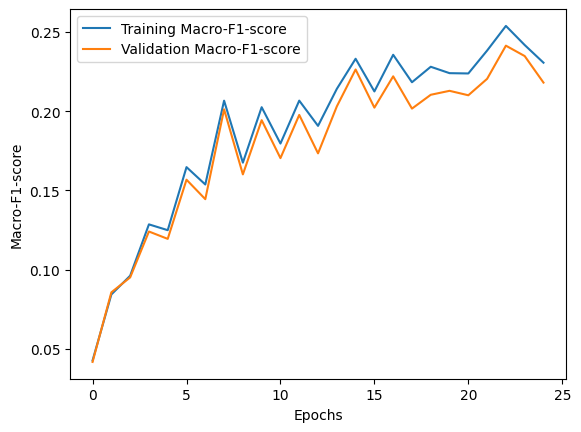

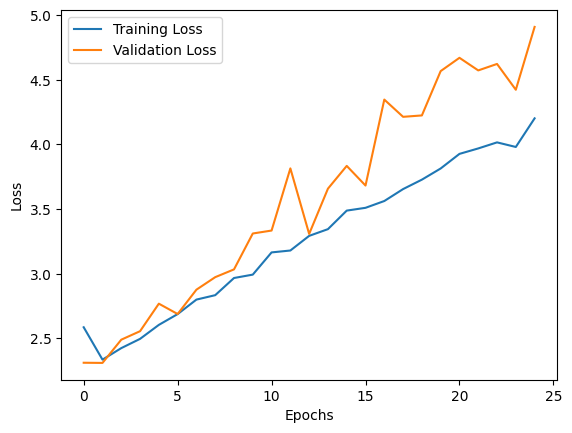

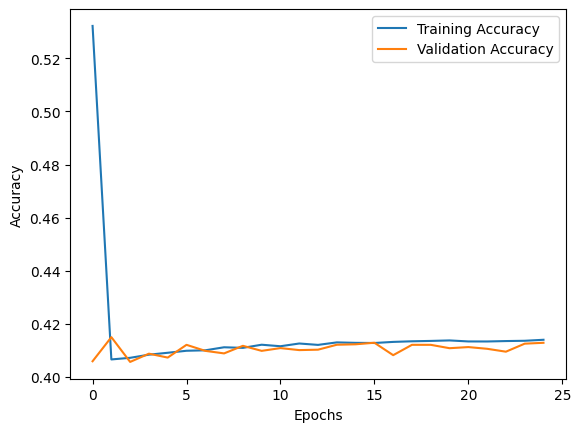

In [19]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(25):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()


In [20]:
model.save('GRU-Dataset1-Word2vec.keras')  # Save the model

In [21]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(45):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()


45/45 [==============================] - 1s 24ms/step
Epoch 1: Training Macro-F1-score: 0.05433311819114692, Validation Macro-F1-score: 0.05323315137491407
Epoch 1: Training Accuracy: 0.9150571227073669, Validation Accuracy: 0.9289649128913879
45/45 [==============================] - 1s 32ms/step
Epoch 2: Training Macro-F1-score: 0.08025183004671534, Validation Macro-F1-score: 0.07853667575729112
Epoch 2: Training Accuracy: 0.9346284866333008, Validation Accuracy: 0.9319410920143127
45/45 [==============================] - 1s 27ms/step
Epoch 3: Training Macro-F1-score: 0.09786923830833107, Validation Macro-F1-score: 0.09768917454587046
Epoch 3: Training Accuracy: 0.9374539256095886, Validation Accuracy: 0.9340193867683411
45/45 [==============================] - 1s 25ms/step
Epoch 4: Training Macro-F1-score: 0.10762478942055086, Validation Macro-F1-score: 0.10874223429225402
Epoch 4: Training Accuracy: 0.9393333792686462, Validation Accuracy: 0.9376412630081177
45/45 [=================

MemoryError: Unable to allocate 214. MiB for an array with shape (8019, 70, 100) and data type float32

In [ ]:
model.save('LSTM-Dataset1-Word2vec.keras')  # Save the model

## Test data

In [2]:
# test data
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data_test = load_data("test_6_8.json")

texts_test = [data_test[key]["text"] for key in data_test]
words_test = [sentence.split() for sentence in texts_test]
nested_labels_test = [data_test[key]["labels"] for key in data_test]

In [3]:
word2vec_model_test = Word2Vec(texts_test, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors_test = {}
for word in word2vec_model_test.wv.index_to_key:
    try:
        word_vectors_test[word.lower()] = word2vec_model_test.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

# Handle out-of-vocabulary (OOV) words in get_word_vector function
def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors_test:
        return word_vectors_test[word_lower]
    else:
        # Choose an appropriate strategy for OOV words:
        # - Return the zero vector (default)
        # - Use word averaging or other embedding techniques
        # - Handle OOV cases differently depending on your specific requirements
        return np.zeros(word2vec_model_test.vector_size)
    
word_embeddings_test = [[get_word_vector(word)  for word in sentence] for sentence in words_test]
max_wordem = max([len(sentence) for sentence in word_embeddings_test])


In [4]:
for sentence in word_embeddings_test:
    sentence_length = len(sentence)
    if sentence_length < 70:
        while len(sentence) < 70: #max_wordem
            sentence.append(np.zeros(100))  
            
# padding to convert into (949, 70, 100)  from (949, variable_length, 70)           
for i in range(len(word_embeddings_test)):
    word_embeddings_test[i] = np.array(word_embeddings_test[i])
word_embeddings_test = np.array(word_embeddings_test)
word_embeddings_test.shape      

(949, 70, 100)

In [5]:
flat_labels = [label for sublist in nested_labels_test for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
# labels_idx = [[label2idx[label] for label in sublist] for sublist in nested_labels]
labels_idx_test = [[label2idx[label] for label in sublist] for sublist in nested_labels_test]

# One-hot encode labels
# num_classes_test = len(unique_labels_test)
one_hot_labels_test = [to_categorical(sublist, num_classes=27) for sublist in labels_idx_test]
print(label2idx)

{'B_OTHER_PERSON', 'B_DATE', 'B_ORG', 'I_COURT', 'B_JUDGE', 'B_CASE_NUMBER', 'B_PROVISION', 'B_RESPONDENT', 'I_WITNESS', 'I_ORG', 'I_GPE', 'I_OTHER_PERSON', 'B_COURT', 'I_STATUTE', 'B_PRECEDENT', 'I_PROVISION', 'B_GPE', 'I_CASE_NUMBER', 'I_PETITIONER', 'I_PRECEDENT', 'O', 'I_RESPONDENT', 'B_STATUTE', 'B_WITNESS', 'I_DATE', 'I_JUDGE', 'B_PETITIONER'}
{'B_OTHER_PERSON': 0, 'B_DATE': 1, 'B_ORG': 2, 'I_COURT': 3, 'B_JUDGE': 4, 'B_CASE_NUMBER': 5, 'B_PROVISION': 6, 'B_RESPONDENT': 7, 'I_WITNESS': 8, 'I_ORG': 9, 'I_GPE': 10, 'I_OTHER_PERSON': 11, 'B_COURT': 12, 'I_STATUTE': 13, 'B_PRECEDENT': 14, 'I_PROVISION': 15, 'B_GPE': 16, 'I_CASE_NUMBER': 17, 'I_PETITIONER': 18, 'I_PRECEDENT': 19, 'O': 20, 'I_RESPONDENT': 21, 'B_STATUTE': 22, 'B_WITNESS': 23, 'I_DATE': 24, 'I_JUDGE': 25, 'B_PETITIONER': 26}


In [27]:
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels_test = convert_to_list(one_hot_labels_test)
# labels_idx[0]

for sentence in one_hot_labels_test:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

one_hot_labels_test = np.array(one_hot_labels_test)
one_hot_labels_test.shape


(949, 70, 27)

In [28]:
X_test_padded = word_embeddings_test
y_test_padded = one_hot_labels_test

# Evaluate the model on the test data
modelS = tf.keras.models.load_model('Simple_RNN-Dataset1-Word2vec.keras')
# modelG = tf.keras.models.load_model('GRU-Dataset1-Word2vec.keras')
# modelL = tf.keras.models.load_model('LSTM-Dataset1-Word2vec.keras')

from sklearn.metrics import classification_report
y_predS = modelS.predict(X_test_padded)
y_pred_classesS = np.argmax(y_predS, axis=2).flatten()
y_test_classesS = np.argmax(y_test_padded, axis=2).flatten()
target_namesS = [str(label) for label in unique_labels]
reportS = classification_report(y_test_classesS, y_pred_classesS, target_names=target_namesS)
print("SimpleRNN", reportS)

# from sklearn.metrics import classification_report
# y_predG = modelG.predict(X_test_padded)
# y_pred_classesG = np.argmax(y_predG, axis=2).flatten()
# y_test_classesG = np.argmax(y_test_padded, axis=2).flatten()
# target_namesG = [str(label) for label in unique_labels]
# reportG = classification_report(y_test_classesG, y_pred_classesG, target_names=target_namesG)
# print("GRU", reportS)

# from sklearn.metrics import classification_report
# y_predL = modelL.predict(X_test_padded)
# y_pred_classesL = np.argmax(y_predS, axis=2).flatten()
# y_test_classesL = np.argmax(y_test_padded, axis=2).flatten()
# target_namesL = [str(label) for label in unique_labels]
# reportL = classification_report(y_test_classesL, y_pred_classesL, target_names=target_namesL)
# print("LSTM", reportL)

30/30 [==============================] - 1s 10ms/step
SimpleRNN                 precision    recall  f1-score   support

         I_GPE       0.00      0.00      0.00        13
        I_DATE       0.00      0.00      0.00        85
     B_STATUTE       0.00      0.00      0.00       205
I_OTHER_PERSON       0.00      0.00      0.00       144
     B_WITNESS       0.00      0.00      0.00        51
   I_PROVISION       0.00      0.00      0.00       468
   I_PRECEDENT       0.05      0.03      0.04      1898
  B_RESPONDENT       0.00      0.00      0.00         4
         B_ORG       0.00      0.00      0.00     33308
       I_JUDGE       0.00      0.00      0.00         3
             O       0.41      0.97      0.57     27520
  B_PETITIONER       0.00      0.00      0.00         8
   B_PROVISION       0.00      0.00      0.00       251
       I_COURT       0.00      0.00      0.00       355
         B_GPE       0.00      0.00      0.00       116
     I_WITNESS       0.00      0.00    

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,